In [1]:
import pandas as pd
from scipy.sparse import load_npz
import numpy as np

# Get DATA_PATH variable from enviroment
path = '/Users/bernardocarvalho/Desktop/imperial_repos/data/'

# Load the item similarity from disk
item_similarity_df = pd.read_csv(path + 'item_similarity.csv', index_col=0)

# Load the utility matrix from disk
utility_matrix_sparse = load_npz(path + 'utility_matrix_sparse.npz')

In [22]:
# Building the recommendation function that takes an item and returns the most similar items

def get_similar_items(item_id, item_similarity_df, similarity_threshold=0.1):
    if item_id not in item_similarity_df.index:
        return item_id

    else:
        # Get the similarity values for the item
        similar_items = item_similarity_df.loc[item_id]
        
        # Sort the items by similarity
        similar_items = similar_items.sort_values(ascending=False)

        # remove items with similarity 0
        similar_items = similar_items[similar_items > 0]

        # remove items with similarity below the threshold
        similar_items = similar_items[similar_items > similarity_threshold]

        # Remove the first row
        similar_items = similar_items[1:]

        return similar_items

In [3]:
def performance_score(submitted_data, test_data):
    # Instantiate the total score
    total_score = 0

    # Calculate the fixed reward (for each purchase, the reward is 1/total number of purchases in the test data)
    fixed_reward = test_data['flg_is_purchase'].sum() / len(test_data['flg_is_purchase'])

    # Sessions in test set that are actually a buy
    S_b = test_data[test_data['flg_is_purchase'] == True]['session_id'].unique()

    for session_id, session in submitted_data.iterrows():

        B_s = test_data[test_data['session_id'] == session_id]['item_id'].unique().tolist()
        A_s = session['similar_items']

        # Get intersection of A_s and B_s
        intersection = list(set(A_s) & set(B_s))
        # Get union of A_s and B_s
        union = list(set(A_s) | set(B_s))
        # Calculate the Jaccard similarity
        if len(union) == 0:
            jaccard_similarity = 0
        else:
            jaccard_similarity = len(intersection) / len(union)

        if session_id in S_b:
            total_score += fixed_reward + jaccard_similarity
        else:
            total_score -= fixed_reward
    return total_score


In [19]:
#Load final predicitons from disk
predictions = np.load(path + 'log_reg_preds_5.npy')    
X_test = pd.read_csv(path + 'X_test.csv')
stream_df = pd.read_csv(path + 'stream_df.csv')

# Create the submission DataFrame
data = stream_df[stream_df['session_id'].isin(X_test[predictions].index.to_list())][['session_id', 'item_id']]

# Group data by id and aggregate the items into a list, keep the last item in a separate column. 
data = data.groupby('session_id')['item_id'].agg(list).reset_index()

# Rename the column of all items
data.rename(columns={'item_id': 'all_items'}, inplace=True)

# Get the last item in the list
data['last_item_id'] = data['all_items'].apply(lambda x: x[-1])

/var/folders/9q/j7lbhmyn7rn9k4c3p7kgjhwh0000gn/T/ipykernel_88223/1139744925.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  stream_df = pd.read_csv(path + 'stream_df.csv')


In [23]:
# Test data = data used in the test split of the model
test_data = stream_df[stream_df['session_id'].isin(X_test.index.to_list())]

# Instantiate a list to hold the performances
performances = []

thresholds = np.linspace(0, 1, 10)

for threshold in thresholds:  # Convert range arguments to integers
    # Apply the get_similar_items function to the last item in each session, removing the ones already in all_items
    data['similar_items'] = data['last_item_id'].apply(lambda x: get_similar_items(x, item_similarity_df, threshold).index.difference(data['all_items'].explode()).tolist())
    performances.append(performance_score(data, test_data))

#Saving files for analysis tomorrow
performances_df = pd.DataFrame({'Performance': performances, 'Threshold': thresholds})

# Save the DataFrame to a CSV file
performances_df.to_csv(path + 'performances', index=False)

# Save the submission data to a CSV file
data.to_csv(path + 'submission_data.csv', index=False)

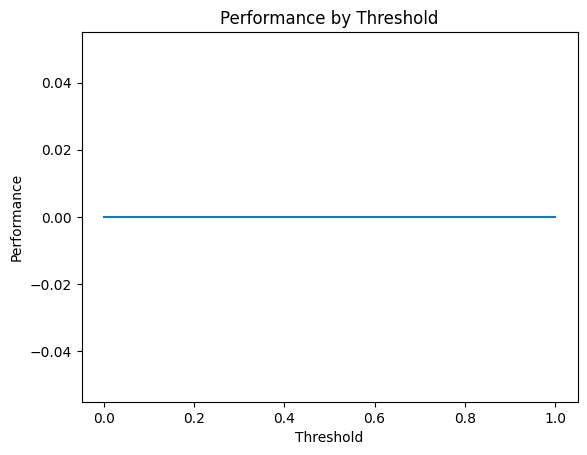

In [ ]:
import matplotlib.pyplot as plt

# Plot the performances
plt.plot(thresholds, performances)

# Add labels and title
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.title('Performance by Threshold')

# Show the plot
plt.show()